In [79]:
import sys
import requests
from urllib import parse
import datetime
import time
import pandas as pd

sys.stdin = open('../dnf_api_key.txt', 'r')

api_key = sys.stdin.readline().strip()

gateway = f"https://api.neople.co.kr/df/"

MyCharacters = ['回歸', '군생활80퍼', '안경자유로', '다시키워용', '싱크마스터', 'KK보벳따우', 
               '뭔활쟁이여', '回歸.', '작명이어려움', '흐아어으어', '사령키우기', '열열다섯', '배미딱',
               '추억의런치', '관짝에들어간', '눈에붕대', '새벽네시야', '나폴리갓바니', '돚거돚돚거', '십오오오',
               '퇴마를키우자', '스시스시스시']

# 캐릭터 기본 정보 검색
def search_info(character_id):
    return gateway + f"servers/cain/characters/{character_id}?apikey={api_key}"

def search_status(character_id):
    return gateway + f"servers/cain/characters/{character_id}/status?apikey={api_key}"

def search_timeline(character_id):
    """
    오늘부터 90일 전까지
    code는 505(아이템 득)만 있어도 될 것 같은데 아이템 강화 관련 코드들은 다 넣어봄 
    """
    end = datetime.datetime.now()
    start = end - datetime.timedelta(days=90)
    end = end.strftime('%Y-%m-%d %H:%M')
    start = start.strftime('%Y-%m-%d %H:%M')
    return gateway + f"servers/cain/characters/{character_id}/timeline?startDate={start}&endDate={end}&code=401,402,403,404,405,406,505,511,513,519,520,521,601,602&apikey={api_key}"

chr_lst = []

for i in range(len(MyCharacters)):
    # 캐릭터 검색
    characterName = parse.quote(MyCharacters[i]) # URL 인코딩
    character = f"servers/cain/characters?characterName={characterName}&apikey={api_key}"
    url = gateway + character
    
    r = requests.get(url)
    
    chr_id = r.json()['rows'][0]['characterId']
    dct = {}
    dct['chacterId'] = chr_id
    url = search_status(chr_id)
    r = requests.get(url)
    reputation_dict = r.json()['status'][16]
    
    dct['reputation'] = reputation_dict['value'] if reputation_dict['name'] == '모험가 명성' else 0
        
    url2 = search_timeline(chr_id)
    r2 = requests.get(url2)
    if r2.json()['timeline']['rows']:
        
        last_get_item = r2.json()['timeline']['rows'][0]['date']
        dct['last_access'] = last_get_item
        
    else:
        dct['last_access'] = (datetime.datetime.now() - datetime.timedelta(days=90)).strftime('%Y-%m-%d %H:%M')

    chr_lst.append(dct)
    time.sleep(0.3)

                           chacterId  reputation       last_access
0   4787c82dd563af3a1e2f833ba575f1f6       30661  2023-03-24 01:02
1   6347bb2fc1c01c75cc014bc719ed7125       19250  2023-03-19 02:30
2   9954bf01b357ebfd3e0983693a9a10b2       16929  2023-03-19 02:33
3   652f7cae62053dc6ce9c98bdd7cac030       18225  2023-03-19 02:34
4   7396c123cb5919f168c34096b46b3aa2       19522  2023-03-19 02:37
5   4bc92779619dc818b9fd78da53706aeb       11788  2023-03-14 01:36
6   8264ebed83a58929b9a31e00d72c7a25       22973  2023-03-11 03:42
7   326e2d7ea4b9ad0685744cdac0aaa415       22583  2023-03-13 01:36
8   2fe8e2131a6d1858b7a5d51c08c8a31c        5439  2023-03-23 01:12
9   3ca245e1eac750802891dbe0ce6fe22a       23530  2023-03-13 01:36
10  ec065c8e36420d0be6d5e47b11813dd1        7684  2023-03-21 02:39
11  904b4bbb4a431ee30f22e8f1a5ef30e4        7722  2023-03-18 01:41
12  062cd4f09c83461ee7da9cb4be7c1285        6633  2023-01-14 23:09
13  c70a3baf6fc092743aba9ef93ec326d5        3472  2023-01-14 2

In [118]:
df = pd.DataFrame(chr_lst)

# df['last_access'] = df['last_access'].astype('datetime64')
df['last_access'] = pd.to_datetime(df['last_access'])

# df.info()

# 던파의 컨텐츠는 주 단위로 있고, 목요일 오전 6시에 초기화됨
# 이번 주는 온전하지 않을 수 있으니 재꼈을 때, 저번 주 목요일(즉 저번 주 컨텐츠)에 아이템을 먹은 기록이 없다면
# 플레이하지 않는 유저라고 간주할 수 있을 것임
today_weekday = datetime.datetime.now().weekday()
if today_weekday < 3:
    today_weekday + 7
x = today_weekday - 3 - 7

base_date = datetime.datetime.now() + datetime.timedelta(days = x)
base_date = base_date.replace(hour = 6, minute = 0, second = 0, microsecond = 0)

df['is_playing'] = df['last_access'].apply(lambda x : True if x >= base_date else False)

def dungeon(x: int):
    if x < 12656:
        return '노말 던전'
    elif x < 16052:
        return '더스크 노말'
    elif x < 17612:
        return '더스크 익스'
    elif x < 24472:
        return '파죽성 노말'
    elif x < 26230:
        return '파죽성 익스'
    elif x < 26933:
        return '더스크 마스터'
    elif x < 30267:
        return '마이스터 노말'
    elif x < 31795:
        return '파죽성 마스터'
    elif x < 33043:
        return '마이스터 익스'
    elif x < 34308:
        return '이스핀즈'
    elif x < 38095:
        return '개전'
    elif x < 40047:
        return '차원회랑'
    else:
        return '바칼 레이드'
    
df['dungeon'] = df['reputation'].apply(lambda x : dungeon(x))
dungeon_order = pd.CategoricalDtype(['노말 던전', '더스크 노말', '더스크 익스', '파죽성 노말', '파죽성 익스',
                                    '더스크 마스터', '마이스터 노말', '파죽성 마스터', '마이스터 익스', '이스핀즈',
                                    '개전', '차원회랑', '바칼 레이드'], ordered = True
                                   )
df['dungeon'] = df['dungeon'].astype(dungeon_order)
df.sort_values('dungeon')

,chacterId,reputation,last_access,is_playing,dungeon
10,ec065c8e36420d0be6d5e47b11813dd1,7684,2023-03-21 02:39:00,False,노말 던전
19,1d95b6d9b711ca027eff9e297c827fde,1639,2023-01-14 23:09:00,False,노말 던전
18,8110d23278c0e26b7332ddcd2dc85214,1219,2023-01-14 23:09:00,False,노말 던전
17,62167f3fe41b2bac4814731b52f99fe1,2099,2023-01-14 23:09:00,False,노말 던전
16,033bcced2f3b60ca38f6320594cafd44,3864,2023-01-14 23:09:00,False,노말 던전
15,83cf0d856acc8e6d56ee9c74a64a52d0,3945,2023-01-14 23:09:00,False,노말 던전
13,c70a3baf6fc092743aba9ef93ec326d5,3472,2023-01-14 23:09:00,False,노말 던전
12,062cd4f09c83461ee7da9cb4be7c1285,6633,2023-01-14 23:09:00,False,노말 던전
11,904b4bbb4a431ee30f22e8f1a5ef30e4,7722,2023-03-18 01:41:00,False,노말 던전
20,61d19eb4ca1134178b5ac103d859de99,10,2023-01-14 23:09:00,False,노말 던전


In [130]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumGothic')
data = df['dungeon'].value_counts().to_frame().reset_index()

,index,dungeon
0,노말 던전,13
1,파죽성 노말,6
2,더스크 익스,1
3,파죽성 익스,1
4,파죽성 마스터,1
5,더스크 노말,0
6,더스크 마스터,0
7,마이스터 노말,0
8,마이스터 익스,0
9,이스핀즈,0


[Text(0, 0, '노말 던전'),
 Text(1, 0, '더스크 노말'),
 Text(2, 0, '더스크 익스'),
 Text(3, 0, '파죽성 노말'),
 Text(4, 0, '파죽성 익스'),
 Text(5, 0, '더스크 마스터'),
 Text(6, 0, '마이스터 노말'),
 Text(7, 0, '파죽성 마스터'),
 Text(8, 0, '마이스터 익스'),
 Text(9, 0, '이스핀즈'),
 Text(10, 0, '개전'),
 Text(11, 0, '차원회랑'),
 Text(12, 0, '바칼 레이드')]

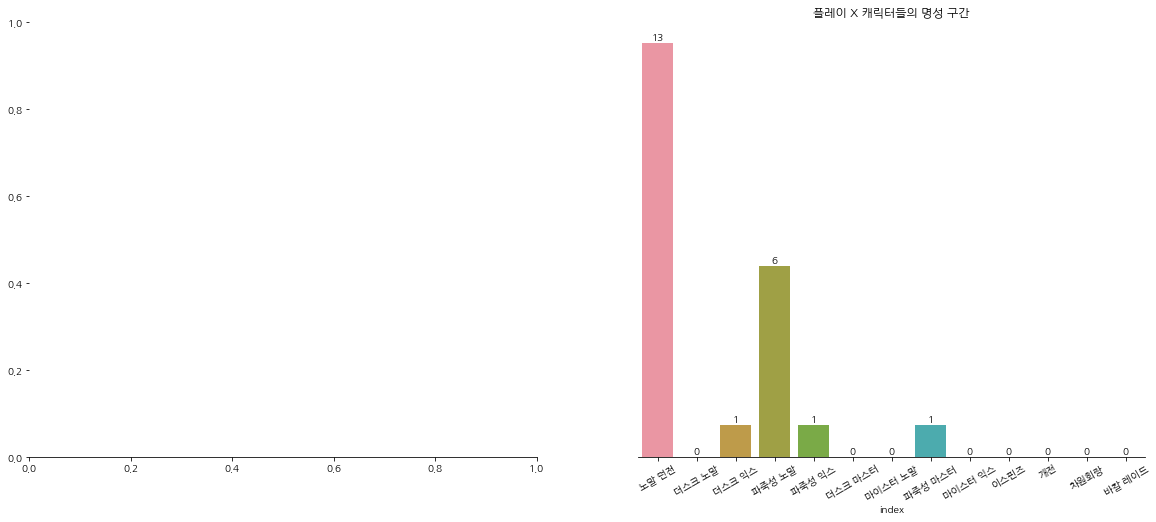

In [157]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))

# 1. 플레이 중인 캐릭터 표시


# 2. 플레이 하지 않는 캐릭터의 명성 구간
ax[1] = sns.barplot(data = df['dungeon'].value_counts().to_frame().reset_index(),
           x = 'index',
           y = 'dungeon',
           )

ax[1].bar_label(ax[1].containers[0])
ax[1].set_title('플레이 X 캐릭터들의 명성 구간')
sns.despine(left = True)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 30)


- 명성 구간을 나누고자 함
- 플레이포인트, 상급 던전을 중요시 하니까 그걸 기준으로 보겠음(상급 던전은 입구컷 기준), 노블레스 코드는 제외
- 레기온 컨텐츠가 열린 시점에 상급 던전(마이스터 마스터)은 제외
1. 역린 주간 11914
2. 더스크 노말 12656
3. 더스크 익스 16052
4. 파죽성 노말 17612
5. 파죽성 익스 24472
6. 더스크 마스터 26230
7. 마이스터 노말 26933
8. 파죽성 마스터 30267
9. 마이스터 익스 31795
10. 이스핀즈 33043 (레기온)
12. 개전 34308
13. 차원회랑 38095
14. 바칼 레이드 40047